## Neural Network forecasting
tensorflow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# PARAMETERS
LAGS        = list(range(1,25))   # past 24h
TEST_YEARS  = 1                    # hold-out years
STEP        = 'H'                  # hourly frequency
EPOCHS      = 100
BATCH_SIZE  = 64
PATIENCE    = 10
ALPHA       = 0.001                # L2 reg
DISPLAY_LEN = 24                 # hours to plot
DATES       = ['2024-01-01','2024-01-08','2024-02-01']

In [3]:
# 1. LOAD DATA (skip comments)
df = pd.read_csv(
    'data/renewables/pv_with_weather_data.csv',
    comment='#', parse_dates=['time']
)
df.rename(columns={'time':'timestamp','electricity':'pv','irradiance_direct':'dir_irr','irradiance_diffuse':'dif_irr','temperature':'temp'}, inplace=True)
df.set_index('timestamp', inplace=True)
# Ensure regular hourly
df = df.asfreq(STEP)

/var/folders/1m/qt1qgmf14_gb0hy_4g7323hc0000gn/T/ipykernel_1802/306943069.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq(STEP)


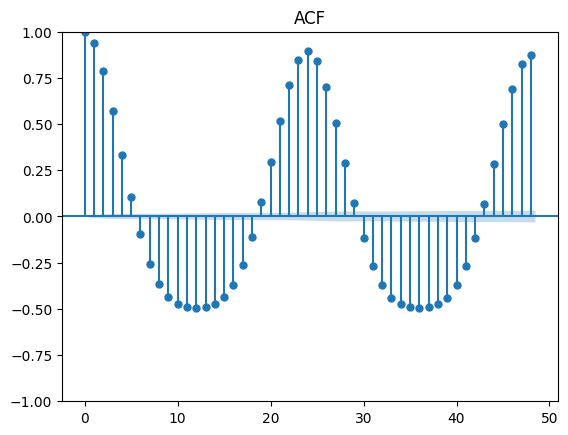

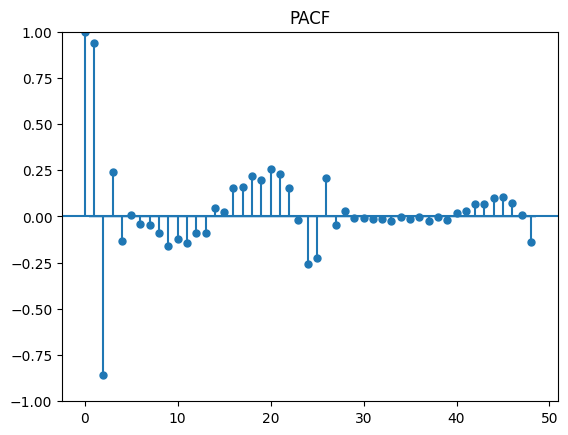

In [4]:
# 2. ACF/PACF ON TARGET
def show_acf_pacf(series, lags=50):
    plot_acf(series.dropna(), lags=lags); plt.title('ACF'); plt.show()
    plot_pacf(series.dropna(), lags=lags, method='ywm'); plt.title('PACF'); plt.show()

show_acf_pacf(df['pv'], lags=48)


In [5]:
# 3. FEATURE ENGINEERING
def make_features(data, lags, include_time=True, include_weather=False):
    X = pd.DataFrame(index=data.index)
    if lags:
        for lag in lags:
            X[f'lag_{lag}'] = data['pv'].shift(lag)
    if include_time:
        X['sin_hour'] = np.sin(2*np.pi*data.index.hour/24)
        X['cos_hour'] = np.cos(2*np.pi*data.index.hour/24)
        X['sin_doy']  = np.sin(2*np.pi*data.index.dayofyear/365)
        X['cos_doy']  = np.cos(2*np.pi*data.index.dayofyear/365)
    if include_weather:
        X['dir_irr'] = data['dir_irr']
        X['dif_irr'] = data['dif_irr']
        X['temp']    = data['temp']
    y = data['pv']
    return X.join(y.rename('target')).dropna()

# build three feature sets:
feats_time      = make_features(df,      lags=LAGS, include_time=True,  include_weather=False)
feats_all       = make_features(df,      lags=LAGS, include_time=True,  include_weather=True)
feats_weather   = make_features(df,      lags=[],   include_time=False, include_weather=True)



In [6]:
# 4. SPLIT FUNCTION
split_date = feats_time.index.max() - pd.DateOffset(years=TEST_YEARS)
def split_feats(feats):
    tr = feats[feats.index <= split_date]
    te = feats[feats.index >  split_date]
    Xtr = tr.drop(columns='target').values; ytr = tr['target'].values
    Xte = te.drop(columns='target').values; yte = te['target'].values
    return Xtr, ytr, Xte, yte, tr.index, te.index

# SPLIT EACH
Xt_tr, yt_tr, Xt_te, yt_te, idx_tr, idx_te = split_feats(feats_time)
Xa_tr, ya_tr, Xa_te, ya_te, ia_tr, ia_te = split_feats(feats_all)
Xw_tr, yw_tr, Xw_te, yw_te, iw_tr, iw_te = split_feats(feats_weather)

# 5. SCALE FEATURES & TARGET
y_scaler   = StandardScaler().fit(yt_tr.reshape(-1,1))
Xt_scaler  = StandardScaler().fit(Xt_tr)
Xa_scaler  = StandardScaler().fit(Xa_tr)
Xw_scaler  = StandardScaler().fit(Xw_tr)

Xt_tr_s, Xt_te_s = Xt_scaler.transform(Xt_tr), Xt_scaler.transform(Xt_te)
Xa_tr_s, Xa_te_s = Xa_scaler.transform(Xa_tr), Xa_scaler.transform(Xa_te)
Xw_tr_s, Xw_te_s = Xw_scaler.transform(Xw_tr), Xw_scaler.transform(Xw_te)

# scale the target for each training set
yt_tr_s = y_scaler.transform(yt_tr.reshape(-1,1)).ravel()
ya_tr_s = y_scaler.transform(ya_tr.reshape(-1,1)).ravel()
yw_tr_s = y_scaler.transform(yw_tr.reshape(-1,1)).ravel()

yt_tr_s = y_scaler.transform(yt_tr.reshape(-1,1)).ravel()


In [7]:
# 6. MODEL BUILDER
def build_model(n_feat):
    m = models.Sequential([
        layers.Input(shape=(n_feat,)),
        layers.Dense(n_feat*2, activation='relu', kernel_regularizer=regularizers.l2(ALPHA)),
        layers.Dropout(0.2),
        layers.Dense(n_feat,   activation='relu', kernel_regularizer=regularizers.l2(ALPHA)),
        layers.Dropout(0.2),
        layers.Dense(1)
    ])
    m.compile(optimizer='adam', loss='mse')
    return m

In [8]:
# 7. TRAIN MODELS
es = callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

model_time = build_model(Xt_tr_s.shape[1])
hist_time  = model_time.fit(Xt_tr_s, yt_tr_s, validation_split=0.2, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=0)

model_all  = build_model(Xa_tr_s.shape[1])
hist_all   = model_all.fit(Xa_tr_s, ya_tr_s, validation_split=0.2, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=0)

model_wthr = build_model(Xw_tr_s.shape[1])
hist_wthr  = model_wthr.fit(Xw_tr_s, yw_tr_s, validation_split=0.2, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=0)


In [9]:
def eval_model(m, Xte, yte):
    yps = m.predict(Xte).flatten()
    ypr = y_scaler.inverse_transform(yps.reshape(-1,1)).ravel()
    mae = mean_absolute_error(yte, ypr)
    rmse = np.sqrt(mean_squared_error(yte, ypr))
    return mae, rmse, ypr

mae_t, rmse_t, pred_t = eval_model(model_time, Xt_te_s, yt_te)
mae_a, rmse_a, pred_a = eval_model(model_all,  Xa_te_s, ya_te)
mae_w, rmse_w, pred_w = eval_model(model_wthr, Xw_te_s, yw_te)
print(f"Time-only    MAE={mae_t:.3f}, RMSE={rmse_t:.3f}")
print(f"All-features MAE={mae_a:.3f}, RMSE={rmse_a:.3f}")
print(f"Weather-only MAE={mae_w:.3f}, RMSE={rmse_w:.3f}")



275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
Time-only    MAE=0.016, RMSE=0.028
All-features MAE=0.006, RMSE=0.009
Weather-only MAE=0.056, RMSE=0.063


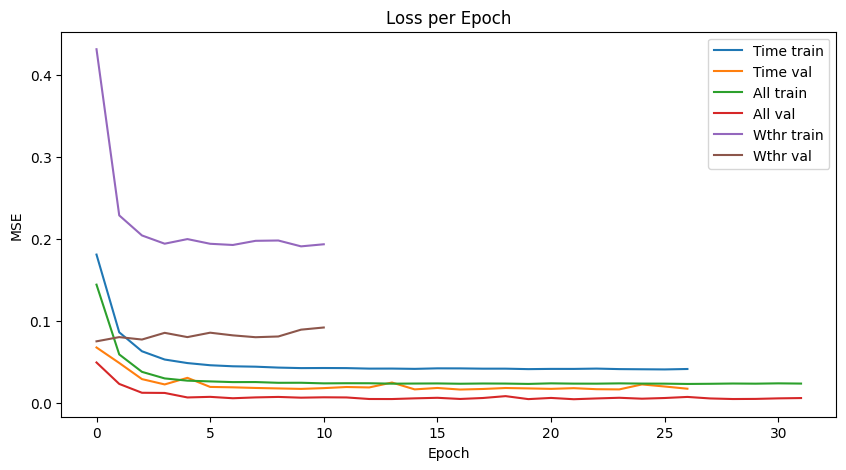

In [10]:
# 9. LOSS CURVES
plt.figure(figsize=(10,5))
plt.plot(hist_time.history['loss'],  label='Time train')
plt.plot(hist_time.history['val_loss'],label='Time val')
plt.plot(hist_all.history['loss'],   label='All train')
plt.plot(hist_all.history['val_loss'],label='All val')
plt.plot(hist_wthr.history['loss'],  label='Wthr train')
plt.plot(hist_wthr.history['val_loss'],label='Wthr val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.title('Loss per Epoch'); plt.show()



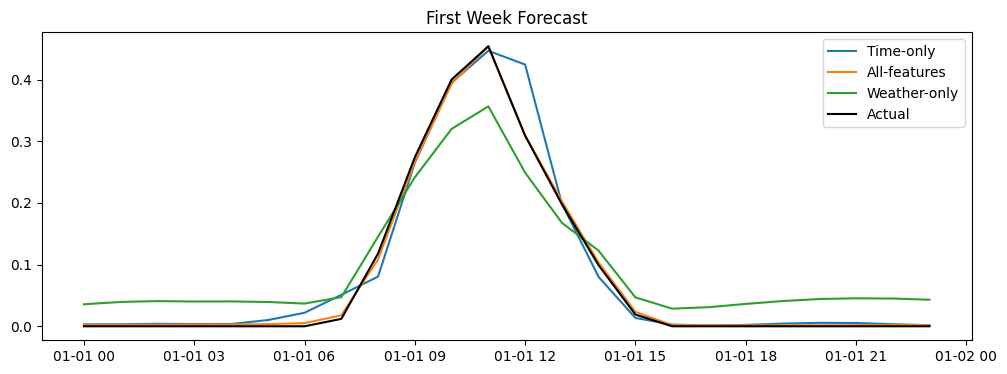

In [11]:
# 10. FIRST WEEK FORECAST COMPARISON
plt.figure(figsize=(12,4))
for pred,label,idx_te in [(pred_t,'Time-only',idx_te),(pred_a,'All-features',ia_te),(pred_w,'Weather-only',iw_te)]:
    plt.plot(idx_te[:DISPLAY_LEN], pred[:DISPLAY_LEN], label=label)
plt.plot(idx_te[:DISPLAY_LEN], yt_te[:DISPLAY_LEN], 'k', label='Actual')
plt.legend(); plt.title('First Week Forecast'); plt.show()



In [12]:
# 11. DAILY MAE SUMMARY
print("Date       | Time-only | All-features | Weather-only")
for d in DATES:
    day = pd.to_datetime(d)
    df_sub = pd.DataFrame({'act':yt_te,'time':pred_t,'all':pred_a,'wthr':pred_w}, index=idx_te)
    sub = df_sub[df_sub.index.normalize()==day]
    if not sub.empty:
        mae1 = np.mean(np.abs(sub['time']-sub['act']))
        mae2 = np.mean(np.abs(sub['all'] -sub['act']))
        mae3 = np.mean(np.abs(sub['wthr']-sub['act']))
        print(f"{d} | {mae1:>8.3f} | {mae2:>11.3f} | {mae3:>13.3f}")
    else:
        print(f"{d} | not in test range")


Date       | Time-only | All-features | Weather-only
2024-01-01 |    0.013 |       0.003 |         0.042
2024-01-08 |    0.009 |       0.004 |         0.044
2024-02-01 |    0.021 |       0.006 |         0.037


In [52]:
# 12. PERMUTATION IMPORTANCE
for name,model,Xte,yte,feat_df in [
    ('Time-only',   model_time, Xt_te_s, yt_te, feats_time),
    ('All-features',model_all,  Xa_te_s, ya_te, feats_all),
    ('Weather-only',model_wthr, Xw_te_s, yw_te, feats_weather)
]:
    print(f"\n{name} feature importances (ΔRMSE):")
    feats = feat_df.drop(columns='target').columns.tolist()
    # baseline
    base = eval_model(model, Xte, yte)[1]
    imps={}
    rng=np.random.RandomState(0)
    for i,fn in enumerate(feats):
        Xp = Xte.copy(); rng.shuffle(Xp[:,i])
                # predict and inverse-scale correctly
        yps = model.predict(Xp).flatten()
        ypr = y_scaler.inverse_transform(yps.reshape(-1,1)).ravel()
        mae_p = mean_absolute_error(yte, ypr)



Time-only feature importances (ΔRMSE):
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
549/549 ━━━━━━